In [2]:
# Hyperparams
 
import torch.nn as nn
import torch
 
# training config
NUM_EPOCHS= 22
LR=0.05
# dataset config
batch_size = 128
generator=torch.Generator().manual_seed(42) # Can be included for reproducability
warm_restarts = False # True means warm restart applied else not
T0 = 1 #epochs at which restarts of LR happen
Tmult = 2 #multiplication factor for LR restart
MOMENTUM=0.9
WT_DECAY=5e-4

In [3]:
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [5]:
NUM_CLASSES = 0
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])
 
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])
def getTrainingSet(dataset_name):
  if dataset_name == 'CIFAR-10':
    print("in cifar-10")
    NUM_CLASSES=10
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
 
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform_test)
    
 
    trainset, validset = torch.utils.data.random_split(trainset, 
                                                      [int(len(trainset)*0.8),len(trainset)- 
                                                      int(len(trainset)*0.8)], generator=generator)
    
  elif dataset_name == 'STL10':
    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    NUM_CLASSES=10
    
    trainset = torchvision.datasets.STL10(root='./data',  split='train',
                                          download=True, transform=transform_train)

    testset = torchvision.datasets.STL10(root='./data', split='test',
                                          download=True, transform=transform_train)
    

    trainset, validset = torch.utils.data.random_split(trainset, 
                                                      [int(len(trainset)*0.8),len(trainset)- 
                                                      int(len(trainset)*0.8)], generator=generator)
  elif dataset_name == 'tiny-imagenet':
    NUM_CLASSES=200
    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
 
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip -qq 'tiny-imagenet-200.zip'
    
    
    totalset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', 
                                                      transform=transform_train)
    
    train_counts = [0] * 200
    valid_counts = [0] * 200
    trainset = []
    validset = []
    testset = []
    for item in totalset:
      if train_counts[item[1]] < 350:
        trainset.append(item)
        train_counts[item[1]] += 1
      elif valid_counts[item[1]] < 75:
        validset.append(item)
        valid_counts[item[1]] += 1
      else:
        testset.append(item)
    
    # trainset = torchvision.datasets.ImageFolder(root='./tiny-imagenet-200/train',
    #                                          transform=transform_train)
 
    # testset = torchvision.datasets.ImageFolder(root='./tiny-imagenet-200/train',
    #                                          transform=transform_test)
    
 
    # trainset, validset = torch.utils.data.random_split(trainset, 
    #                                                   [int(len(trainset)*0.8),len(trainset)- 
    #                                                   int(len(trainset)*0.8)], generator=generator)
 
  elif dataset_name == 'Caltech101':
    NUM_CLASSES=101
    !gdown https://drive.google.com/uc?id=1DX_XeKHn3yXtZ18DD7qc1wf-Jy5lnhD5
    !unzip -qq '101_ObjectCategories.zip' 
 
    PATH = '101_ObjectCategories/'
    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    totalset = torchvision.datasets.ImageFolder(PATH, transform=transform_train)
 
    X, y = zip(*totalset)
 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, 
                                                      stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
                                                    test_size = 0.5, 
                                                    stratify=y_val)
 
    trainset, validset, testset = list(zip(X_train, y_train)), list(zip(X_val, y_val)), list(zip(X_test, y_test))
 
 
 
 
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
  validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                            shuffle=False,num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  return trainset, testset, validset, trainloader, testloader, validloader, NUM_CLASSES

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class ResNetBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [9]:
def ResNet18():
    return ResNet(ResNetBasicBlock, [2,2,2,2], NUM_CLASSES)

In [10]:
class VGGStyleNet(nn.Module):
    def __init__(self, num_classes: int = 10, init_weights: bool = True): #change num_Class acording to the dataset
        super(VGGStyleNet, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2)
        self.classifier = nn.Sequential(
            nn.Linear(128*8*8, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()
    
    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        out = F.relu(self.conv1_1(x))
        out = F.relu(self.conv1_2(out))
        out = self.maxpool1(out)
        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.maxpool2(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [21]:
# Model
trainset, testset, validset, trainloader, testloader, validloader, NUM_CLASSES = getTrainingSet("STL10") #change dataset
# net = ResNet18()
net = VGGStyleNet()
total_parameters = sum(p.numel() for p in net.parameters())
print(total_parameters)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
50640970


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WT_DECAY)

In [14]:
if warm_restarts == True:
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=T0, 
        T_mult=Tmult,
        verbose=True
    )
else:
  listM = []
  i = T0
  MF = Tmult*i
  while i <= NUM_EPOCHS:
    listM.append(i)
    i =i+ MF
    MF=MF*2
  print(listM)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=listM,gamma=0.2)
  print("not warm restarts")

[1, 3, 7, 15]
not warm restarts


In [15]:
def train(epoch):
  net.train()
  correct_images = 0
  total_images = 0
  training_loss = 0
  LRlistIteration = []
  trainLossIteration = []
  for batch_index, (images, labels) in enumerate(trainloader):
    if batch_index % 500 == 0:
        print("Learning rate at every 500 iteration interval for batch index is",batch_index, scheduler.get_last_lr())
    LRlistIteration.append(scheduler.get_last_lr()[0])
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if warm_restarts == True:
      scheduler.step(epoch + batch_index / len(trainloader))
    training_loss += loss.item()
    _, predicted = outputs.max(1)
    total_images += labels.size(0)
    correct_images += predicted.eq(labels).sum().item()
    print('Epoch: %d, Batch: %d, Loss: %.3f, '
                  'Accuracy: %.3f%% (%d/%d)' % (epoch, batch_index, training_loss/(batch_index+1),
                                           100.*correct_images/total_images, correct_images, total_images))
    trainLossIteration.append(training_loss/(batch_index+1))
  return training_loss/(batch_index+1), scheduler.get_last_lr()[0], LRlistIteration, trainLossIteration

In [16]:
def validate(epoch):
    net.eval()
    validation_running_loss = 0.0
    total_images = 0
    correct_images = 0
    valLossIteration = []
    with torch.no_grad():
      for batch_index, (images, labels) in enumerate(validloader):
          # images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)

          validation_running_loss += loss.item()
          _, predicted = outputs.max(1)
          total_images += labels.size(0)
          correct_images += predicted.eq(labels).sum().item()
          print('Epoch: %d, Batch: %d, Loss: %.3f, '
                  'Accuracy: %.3f%% (%d/%d)' % (epoch, batch_index, validation_running_loss/(batch_index+1),
                                           100.*correct_images/total_images, correct_images, total_images))
          valLossIteration.append(validation_running_loss/(batch_index+1))
          epoch_loss = validation_running_loss / (batch_index+1)
    return epoch_loss, valLossIteration
  

In [17]:
def test():
    test_loss = 0
    total_images = 0
    correct_images = 0
    net.eval()
    with torch.no_grad():
      for batch_index, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_images += labels.size(0)
        correct_images += predicted.eq(labels).sum().item()
        print(batch_index, len(testloader), 'Loss: %.3f | Accuracy: %.3f%% (%d/%d)'
                  % (test_loss/(batch_index+1), 100.*correct_images/total_images, correct_images, total_images))
        test_accuracy = 100.*correct_images/total_images
    print("accuracy of test set is",test_accuracy)
    return test_loss/(batch_index+1)

In [22]:
train_loss, val_loss = [], []
learning_rate_per_iteration = []
learning_rate_per_epoch = []
LRlistIteration = []
train_loss_per_iteration = []
val_loss_per_iteration = []
for epoch in range(NUM_EPOCHS):
  training_epoch_loss, LR, LRs, trainLossIteration = train(epoch) 
  #In 1 epoch 48% accuracy
  validation_epoch_loss, valLossIteration =validate(epoch)
  train_loss.append(training_epoch_loss)
  val_loss.append(validation_epoch_loss)
  learning_rate_per_epoch.append(LR)
  train_loss_per_iteration.extend(trainLossIteration)
  val_loss_per_iteration.extend(valLossIteration)
  learning_rate_per_iteration.extend(LRs)
  if warm_restarts == False:
    scheduler.step() # take default MultiStepLR
  print(f"[INFO]: Current LR [Epoch end]: {scheduler.get_last_lr()}")
  print(f"Training loss: {training_epoch_loss:.3f}")
  print(f"Validation loss: {validation_epoch_loss:.3f}")
  print('-----------------------***---------------------------')

Learning rate at every 500 iteration interval for batch index is 0 [0.05]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Batch: 0, Loss: 2.292, Accuracy: 14.062% (18/128)


KeyboardInterrupt: ignored

train loss list is []
val loss list is  []
lr per epoch is []


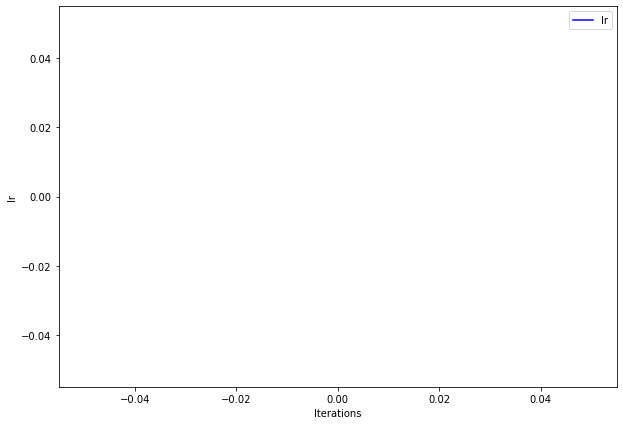

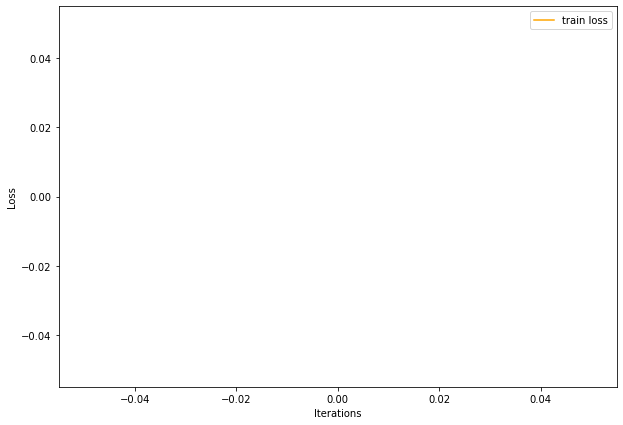

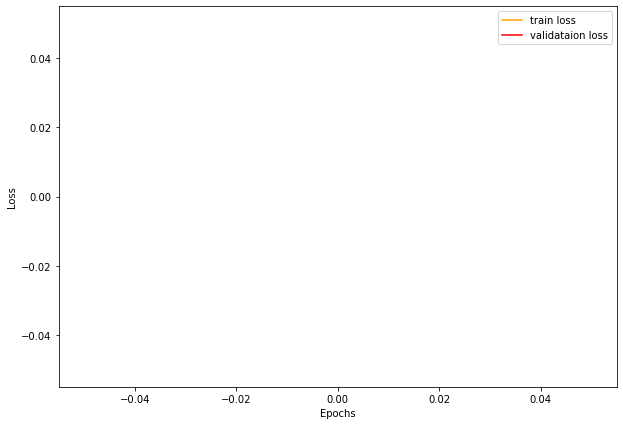

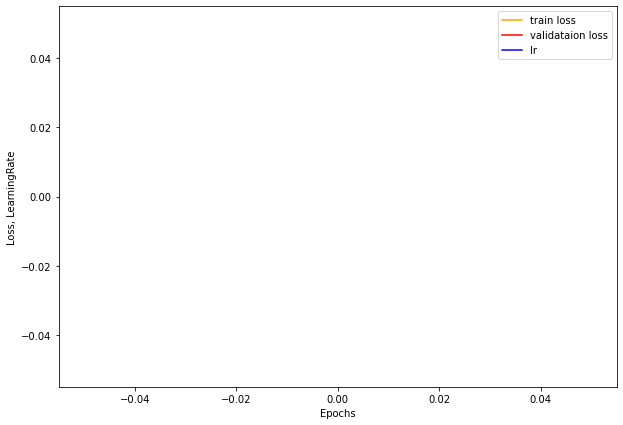

In [19]:
plt.figure(figsize=(10, 7))
plt.plot(learning_rate_per_iteration, color='blue', label='lr')
plt.xlabel('Iterations')
plt.ylabel('lr')
plt.legend()
plt.savefig(f"lr_schedule_for_T0={T0}_Tmult={Tmult}.jpg")

plt.figure(figsize=(10, 7))
plt.plot(train_loss_per_iteration, color='orange', label='train loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"training_loss_per_iteration.jpg")

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"training_and_validation_loss_per_epoch.jpg")

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.plot(learning_rate_per_epoch, color='blue', label='lr')
plt.xlabel('Epochs')
plt.ylabel('Loss, LearningRate')
plt.legend()
plt.savefig(f"Loss_and_learning_rate_for_T0={T0}_Tmult={Tmult}.jpg")

print("train loss list is", train_loss)
print("val loss list is ", val_loss)
print("lr per epoch is", learning_rate_per_epoch)

In [20]:
test_loss = test()
print("test_loss is", test_loss)

NameError: ignored